In [2]:
import os
import cv2
import numpy as np
import torch
import torchvision
from PIL import Image
from albumentations import Compose, RandomScale, RandomSizedCrop, RandomCrop, Resize, \
    HorizontalFlip, Rotate, Lambda, VerticalFlip, Normalize, \
    CenterCrop, Downscale, ElasticTransform, GaussianBlur, GaussNoise, GridDistortion, \
    HueSaturationValue, MedianBlur, MotionBlur, OneOf, PadIfNeeded, \
    RandomBrightnessContrast
from albumentations.pytorch.transforms import ToTensorV2
from seg_hrnet import hrnet
from yacs.config import CfgNode
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

In this exercise, we will train a model to detect mask for hands. 
First of all, we have implemented a Pytorch Dataset used for training and evaluation.

In [3]:
class HandDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir="./eyth_dataset", mode="train", transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.sample_paths = open(os.path.join(self.root_dir, f"train-val-test-split/{mode}.txt")).read().split()
#         self.sample_paths = self.sample_paths[:int(len(self.sample_paths)/2)]
    
    def __getitem__(self, index):
        sample_path = self.sample_paths[index]
        image_path = os.path.join(self.root_dir, 'images', sample_path)
        mask_path = os.path.join(self.root_dir, 'masks', sample_path.replace('jpg', 'png'))
        image_np = cv2.imread(image_path)
        mask_np = cv2.imread(mask_path, 0)
        mask_np[mask_np==255] = 1
        
        if self.transform is not None:
            transformed = self.transform(image=image_np, mask=mask_np)
            return transformed['image'], transformed['mask']
        return image_np, mask_np

    def __len__(self):
        return len(self.sample_paths)


We take a look about the dataset. Our target is to train a model such that by inputing a image, it will predict hand's mask. 

Num of training samples 774 
Image shape: (216, 384, 3) 
Mask shape: (216, 384)
mask 0 unique values: [0 1]
mask 1 unique values: [0 1]
mask 2 unique values: [0 1]
mask 3 unique values: [0 1]
mask 4 unique values: [0 1]


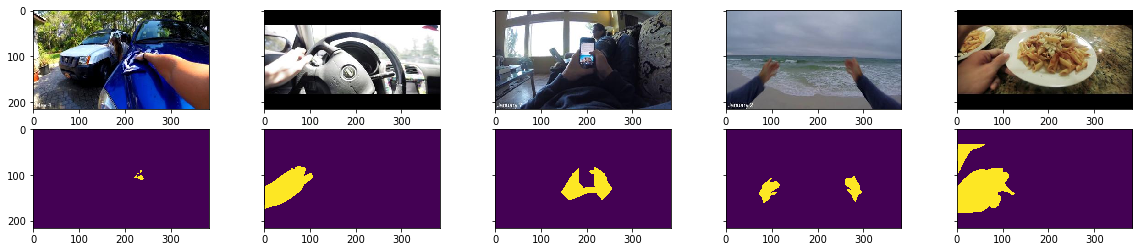

mask 5 unique values: [0 1]
mask 6 unique values: [0 1]
mask 7 unique values: [0 1]
mask 8 unique values: [0 1]
mask 9 unique values: [0 1]


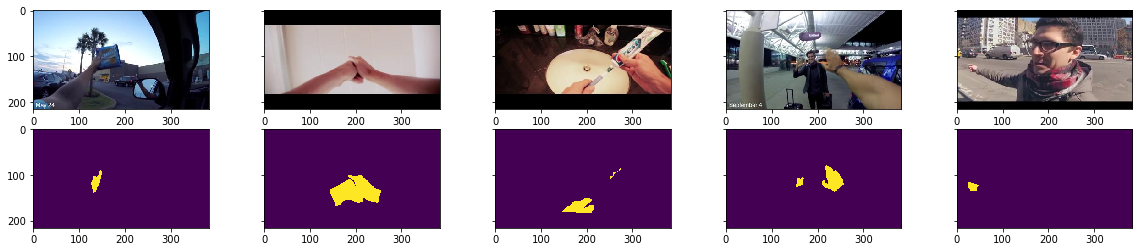

mask 10 unique values: [0]
mask 11 unique values: [0 1]
mask 12 unique values: [0 1]
mask 13 unique values: [0 1]
mask 14 unique values: [0 1]


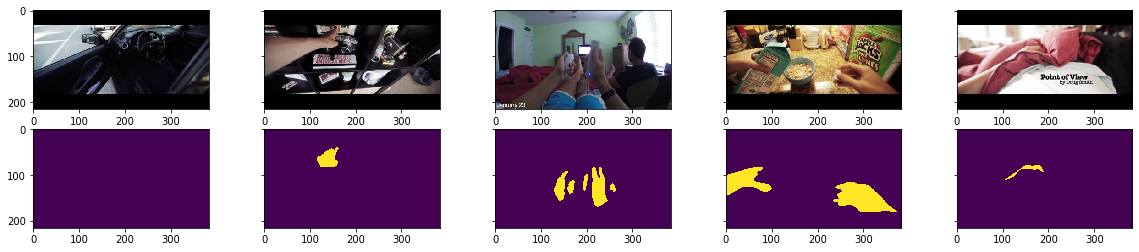

mask 15 unique values: [0 1]
mask 16 unique values: [0 1]
mask 17 unique values: [0 1]
mask 18 unique values: [0 1]
mask 19 unique values: [0 1]


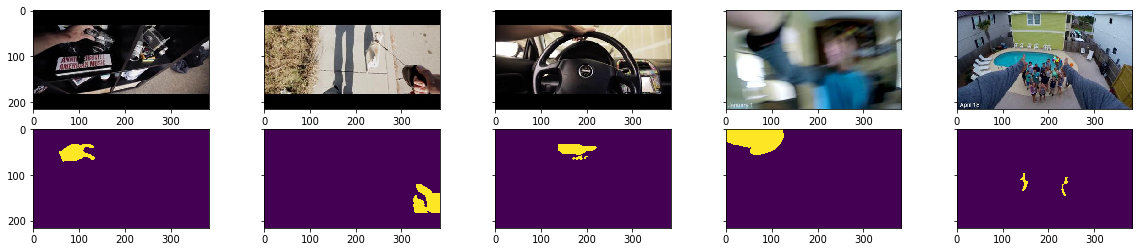

In [4]:
dataset = HandDataset(mode="train")
image, mask = dataset[0]
print("Num of training samples", len(dataset), "\nImage shape:", image.shape, "\nMask shape:", mask.shape)

max_sample_to_show = 20
fig, axs = plt.subplots(2,5, sharey=True)
fig.set_figwidth(20)
for i in range(max_sample_to_show):
    image, mask = dataset[i]
    image_rbg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[0, i%5].imshow(Image.fromarray(image_rbg))  # we convert numpy image to Pillow Image, in order to plot them 
    axs[1, i%5].imshow(Image.fromarray(mask))
    print(f"mask {i} unique values:", np.unique(mask))
    if i % 5 == 4:
        plt.show()
        if i < max_sample_to_show - 1:
            fig, axs = plt.subplots(2, 5, sharey=True)
            fig.set_figwidth(20)

In [5]:
transform_test = Compose([Normalize(), ToTensorV2()])

TODO (Part 1): You need to provide suitable preprocessing to image and mask.
HINTS: use albumentations, check https://github.com/albumentations-team/albumentations


In [6]:
# TODO define preprocessing for training set
transform_train = ...

In [6]:
dataset_train = HandDataset(mode="train", transform=transform_train)
dataset_val = HandDataset(mode="val", transform=transform_test)
dataset_test = HandDataset(mode="train", transform=transform_test)

We will use fcn_resnet101 to train a segmentation model. Let's define model and see how to use it. 

In [ ]:
def build_model(num_classes):
    cfg = CfgNode()
    cfg.MODEL = CfgNode()
    cfg.MODEL.NUM_CLASSES = num_classes
    model = hrnet(cfg)
    return model

# we define a model with 2 classes
model = build_model(2) 
model.cuda()

# we try to feed a validation image into the model
x, y = dataset_val[0]
outputs = model(torch.stack([x]).cuda())
print("model outputs:", x.shape, y.shape, outputs.shape)


TODO (Part 2): Define loss function, optimizer, scheduler in order to train the model

In [12]:
# define pytorch dataloader
dataloader_train = ...
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, num_workers=2)


# TODO define loss function
criterion = ...

# TODO define optimizer to optimize model weight
optimizer = ...

# TODO define scheduler to update learning rate
scheduler = ...

# TODO define number of epoch to train
num_epoches = ...

TODO (Part3): Implement evaluation, i.e. eval_model. The metric we will use is mean Intersection-Over-Union (mIOU).
You need to calculate IOU for both background pixels and hand pixels, and take the average as accuracy. 

Definition of IOU for background: 
  Number of overlapped pixels of background bewtween true mask & predicted mask / Number of union pixels of background bewtween true mask & predicted mask
  - If Number of union pixels = 0, then IOU for background = 1
  
Definition of IOU for hand is similar.


In [9]:
def eval_model(model, dataloader_test):
    model.eval()
    images_miou = []
    with torch.no_grad():
        for step_idx, (batch_inputs, batch_targets) in enumerate(dataloader_test):
            outputs = model(batch_inputs.cuda())
            # TODO: calculate background IOU and hand IOU 
            ...
            
            mIOU = (background_iou + hand_iou)/2 
            if step_idx % 30 == 0:
                print(f'step_idx: {step_idx}, mIOU = {mIOU:.2f}, background: {background_iou:.2f}, hand: {hand_iou:.2f}')
            images_miou.append(mIOU)
    accuracy = sum(images_miou)/len(images_miou)
    print(f'Model accuracy: {accuracy:.2f}')
    return accuracy

TODO (Part 4): Implement optimization flow, i.e. train_model 

In [10]:
def train_model(model, criterion, optimizer, scheduler, dataloader_train, dataloader_val, num_epoches):
    # loop epoch
    for epoch_idx in range(num_epoches):
        print(f'Epoch: {epoch_idx}, learning rate:', optimizer.param_groups[0]['lr'])
        # loop dataloader_train
        model.train()
        for step_idx, (batch_inputs, batch_targets) in enumerate(dataloader_train):
            # TODO implement train step: forward pass, calculate loss, optimize model 
            ...
            
            if step_idx % 10 == 0:
                print(f"Epoch: {epoch_idx}, Step: {step_idx + 1}/{len(dataloader_train)}, Loss: {loss}")
        if scheduler is not None:
            scheduler.step()
        
        # loop dataloader_val to calculate val_loss for validation set
        model.eval()
        val_loss_total = 0
        with torch.no_grad():
            for batch_inputs, batch_targets in dataloader_val:
                outputs = model(batch_inputs.cuda())
                val_loss = criterion(outputs, batch_targets.long().cuda())
                val_loss_total += val_loss
        val_loss = val_loss_total / len(dataloader_val)
        val_accuracy = eval_model(model, dataloader_val) 
        print(f"Epoch: {epoch_idx}, val_loss = {val_loss}, val_accuracy = {val_accuracy:.2f}")

In [ ]:
# train the model
train_model(model, criterion, optimizer, scheduler, dataloader_train, dataloader_val, num_epoches)

In [ ]:
# calculate model accuracy on test set 
eval_model(model, dataloader_test)

TODO (Part 5): Inferece test dataset and visualize the hand mask prediction.

Image 0


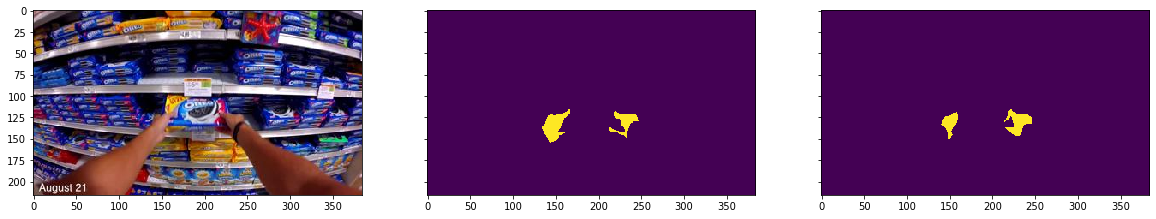

Image 1


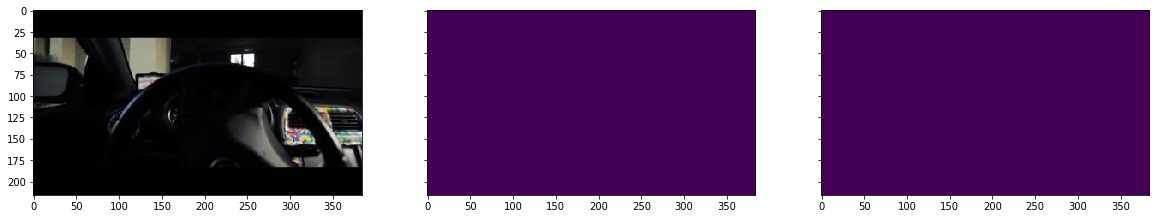

Image 2


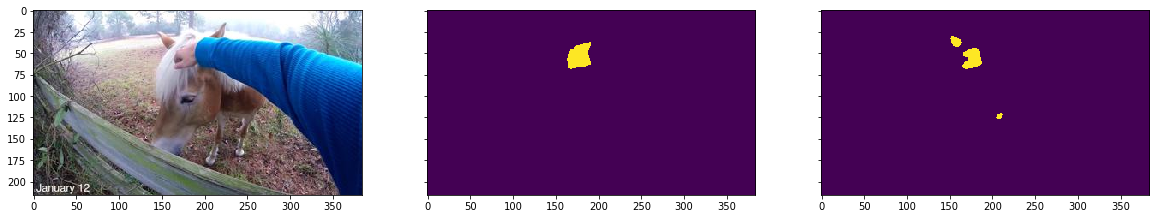

Image 3


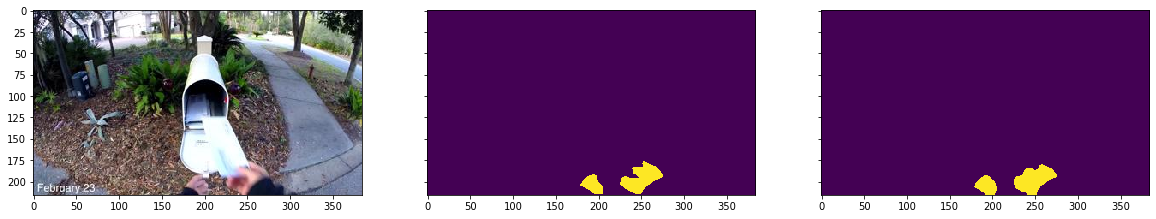

Image 4


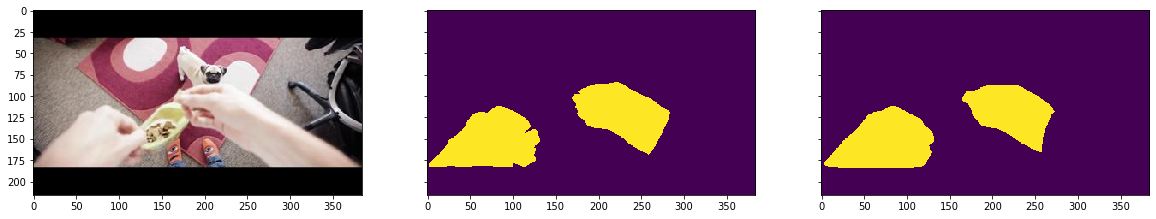

Image 5


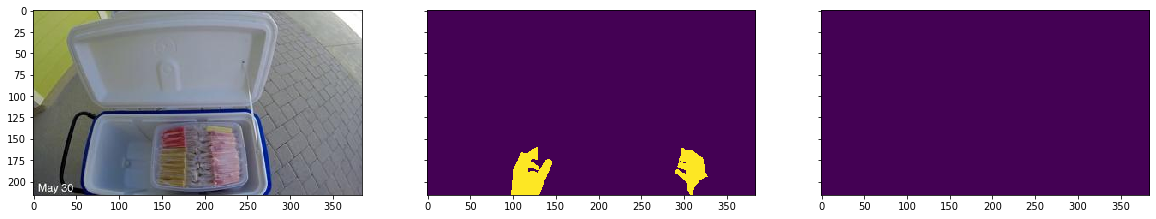

Image 6


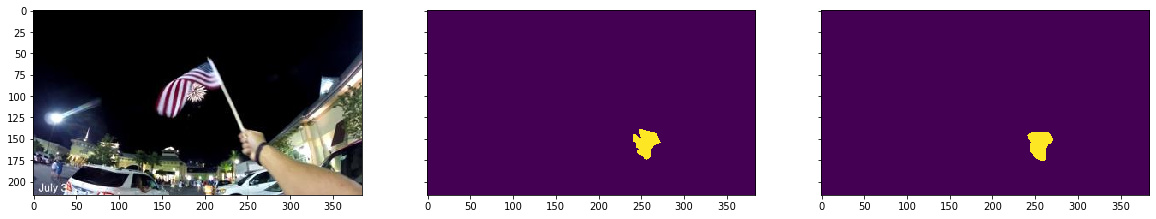

Image 7


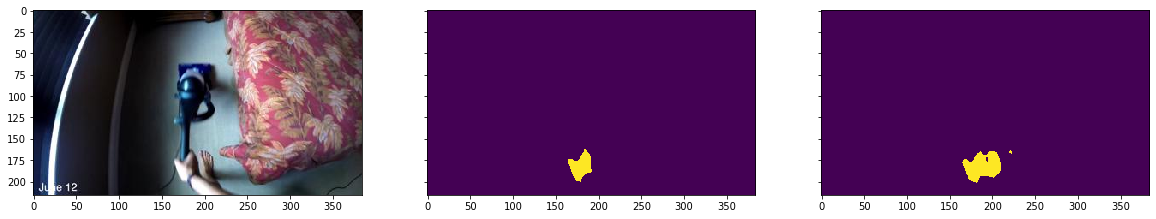

Image 8


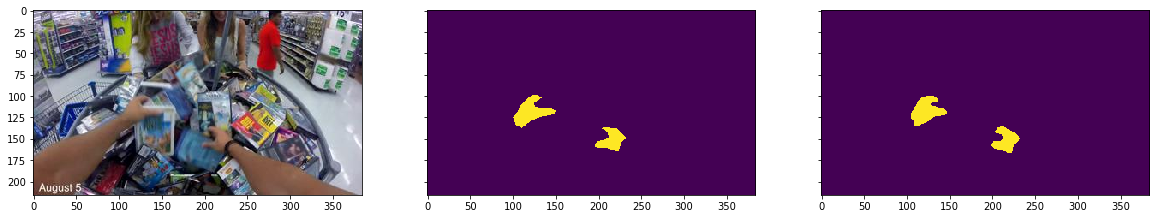

Image 9


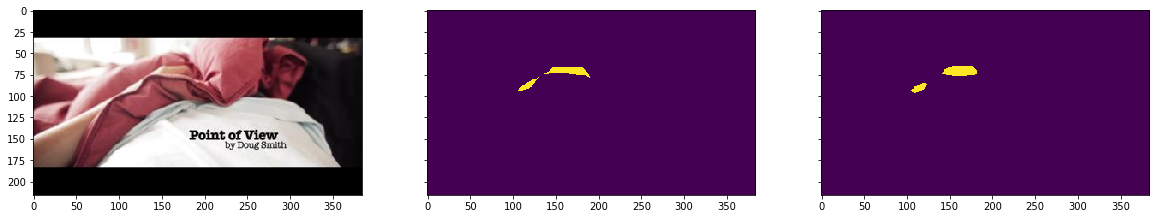

Image 10


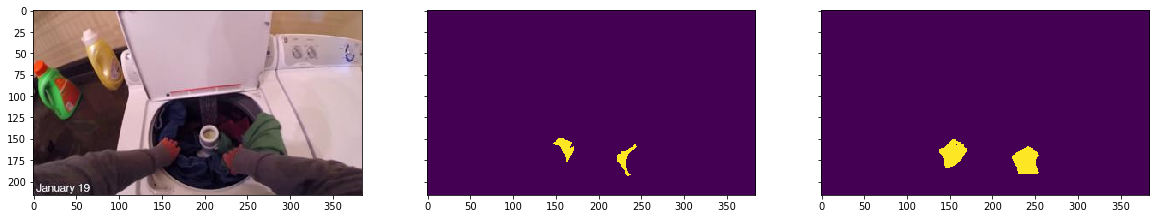

Image 11


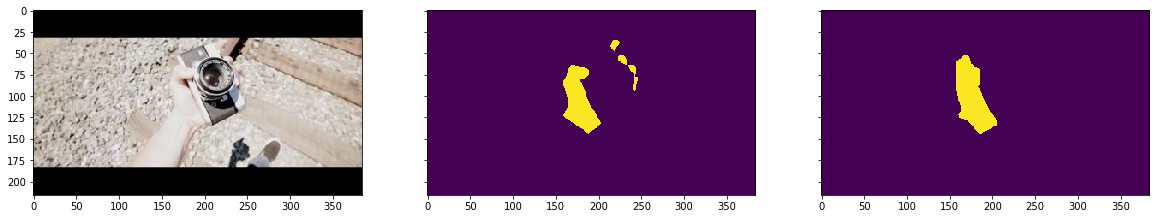

Image 12


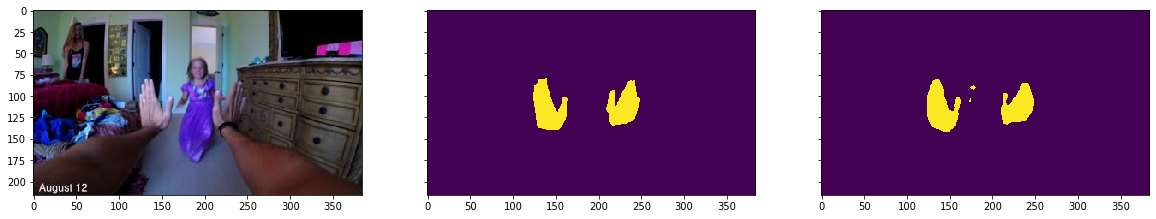

Image 13


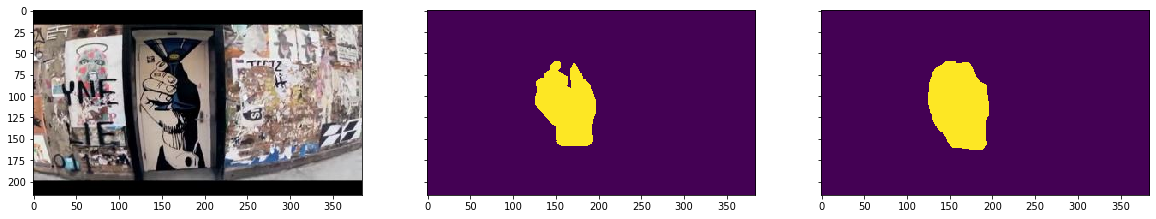

Image 14


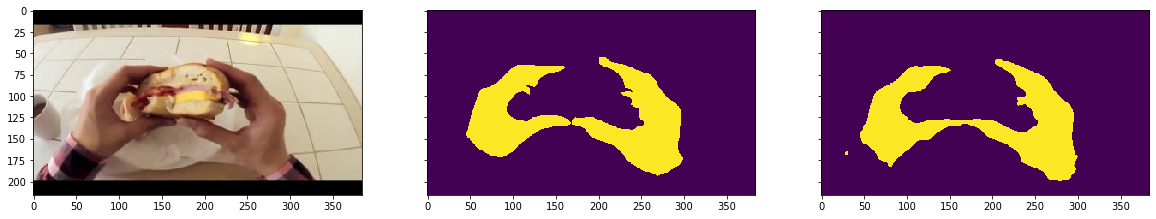

Image 15


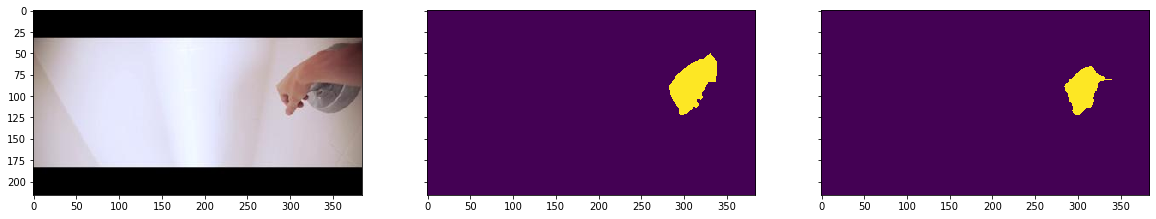

Image 16


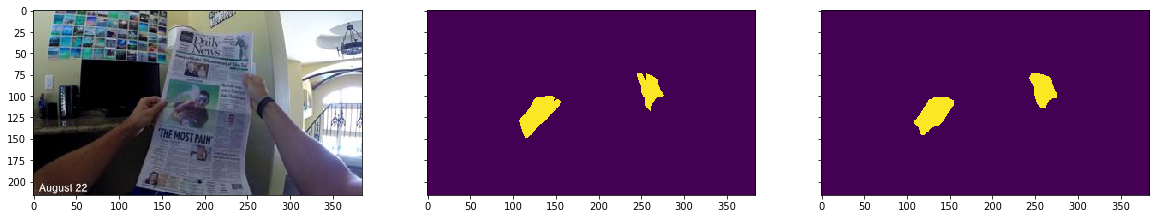

Image 17


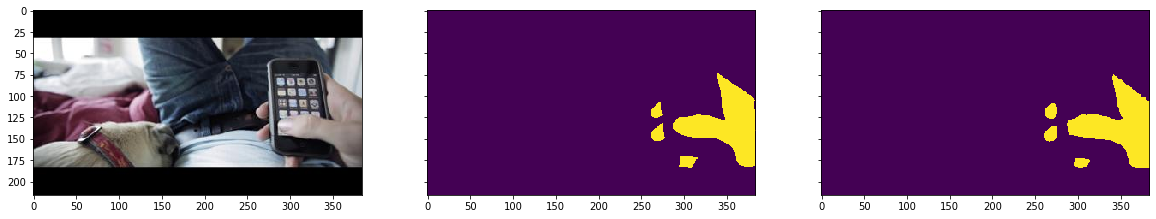

Image 18


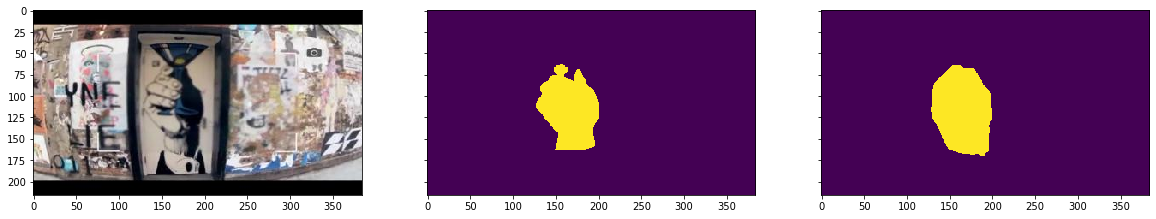

Image 19


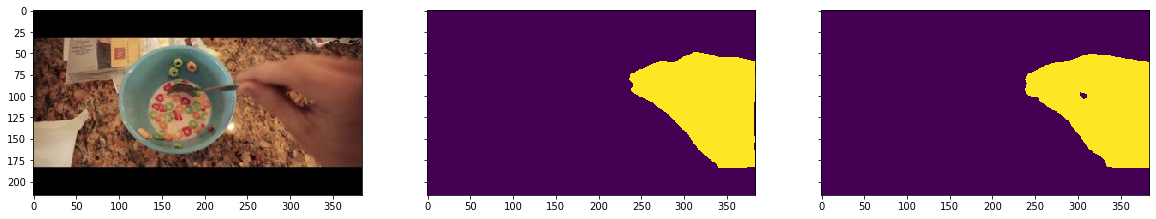

Image 20


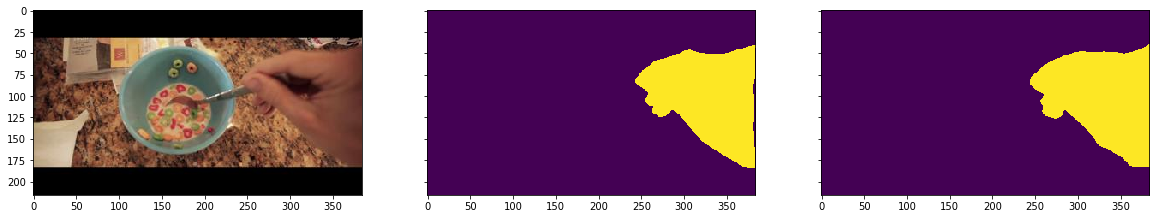

Image 21


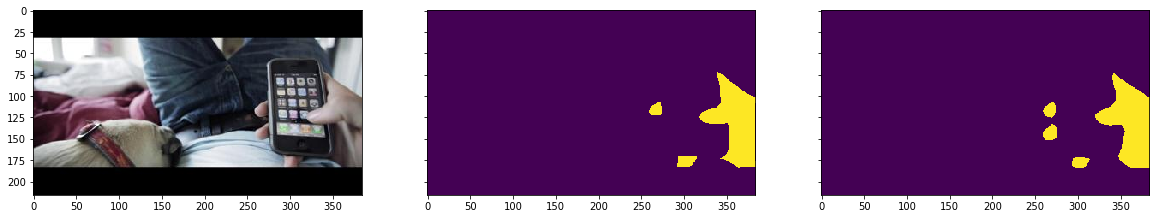

Image 22


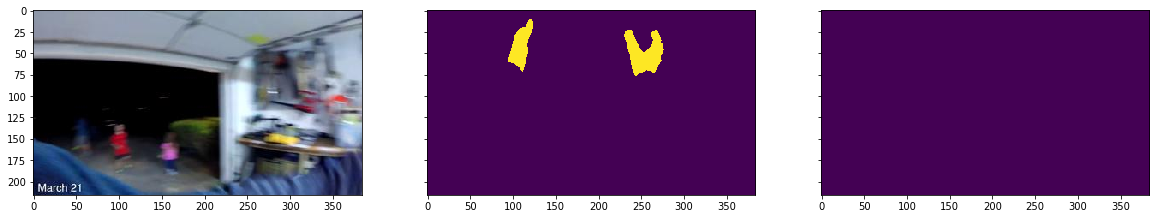

Image 23


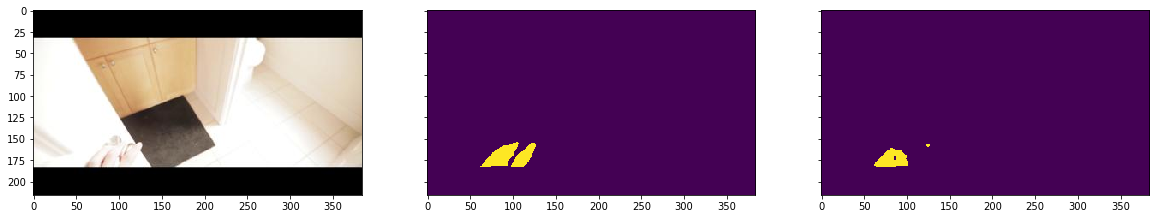

Image 24


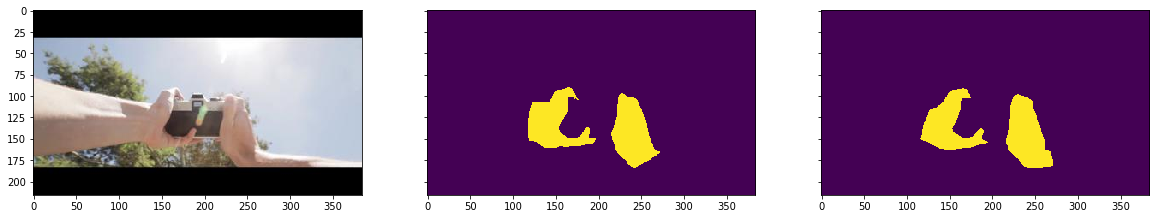

Image 25


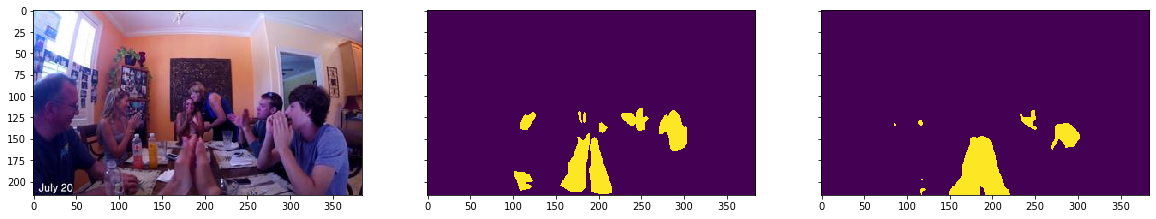

Image 26


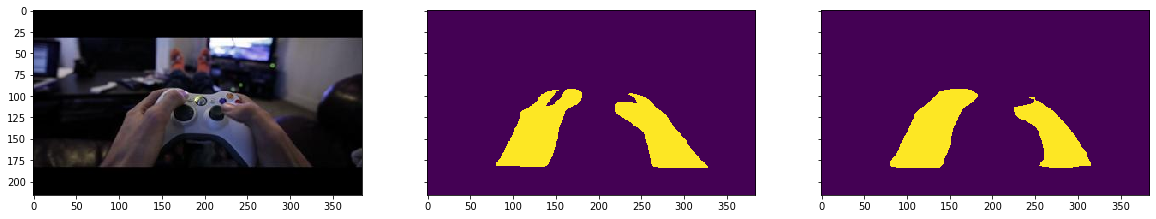

Image 27


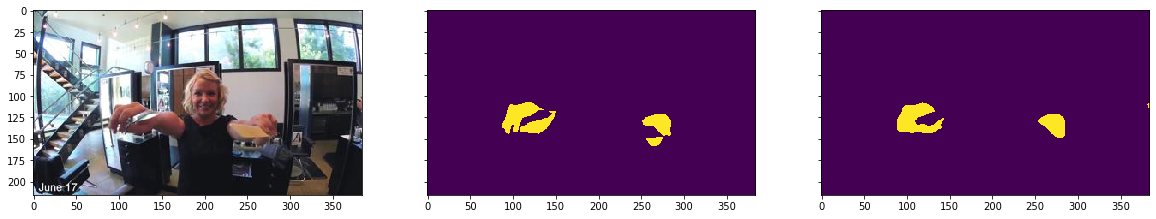

Image 28


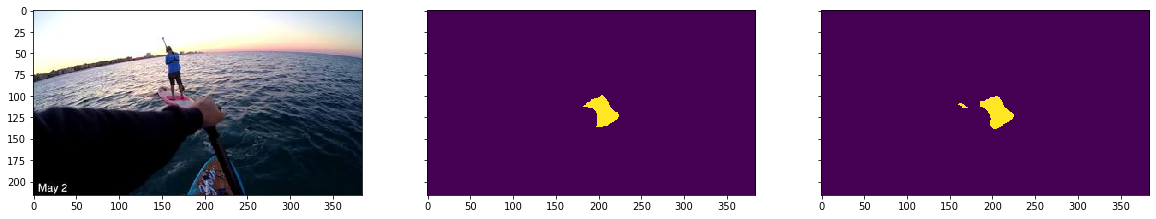

Image 29


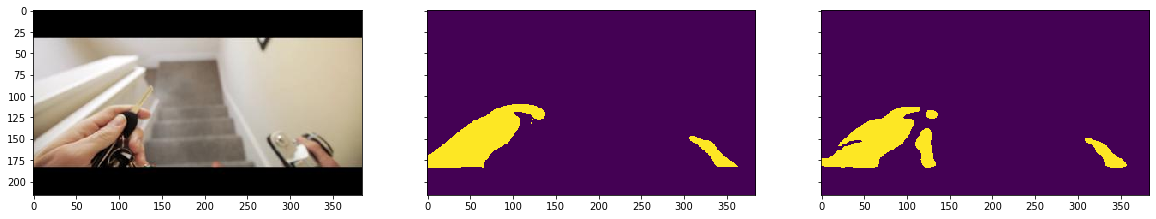

Image 30


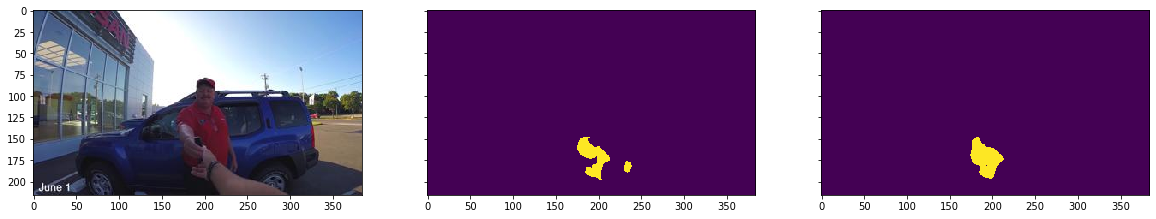

Image 31


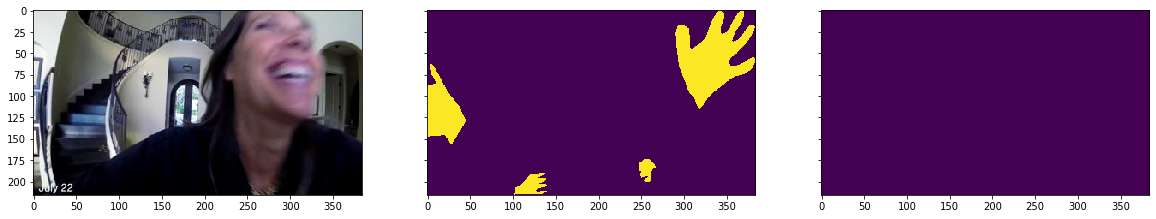

Image 32


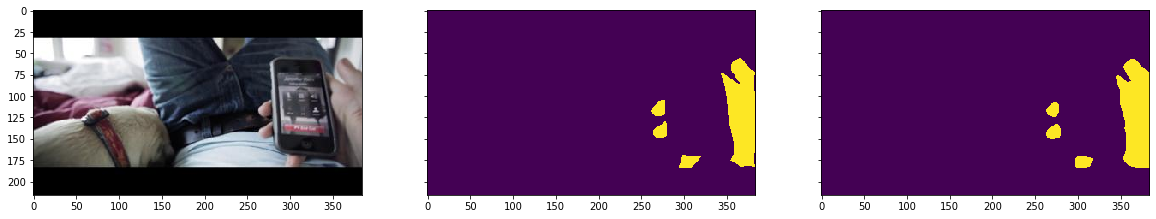

Image 33


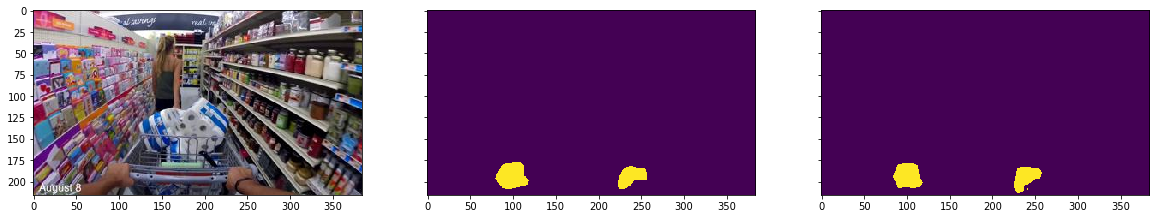

Image 34


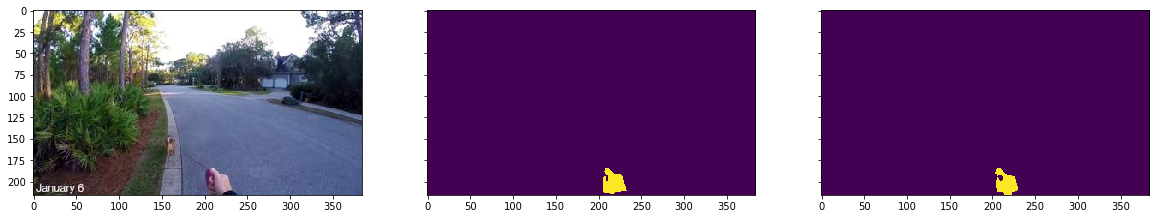

Image 35


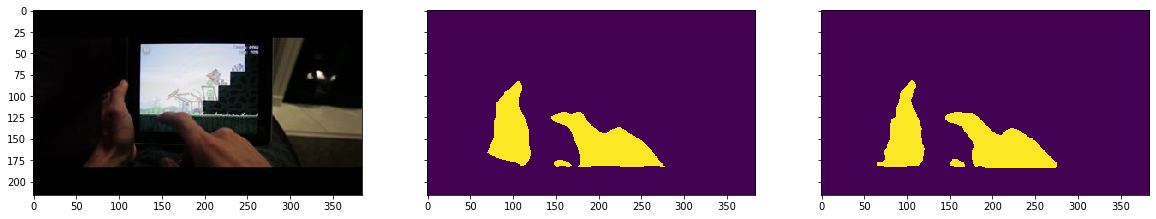

Image 36


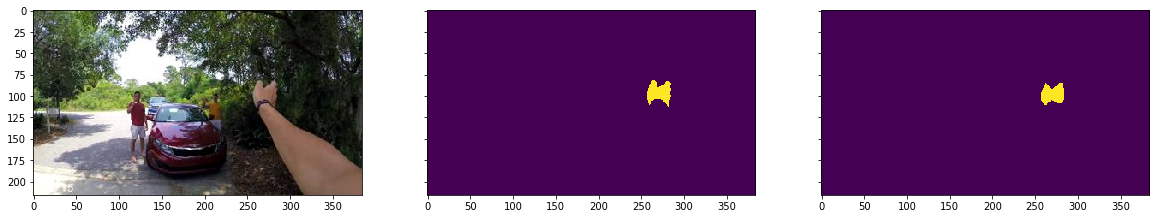

Image 37


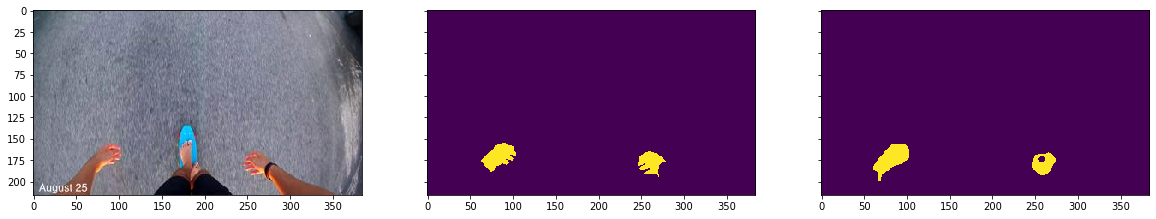

Image 38


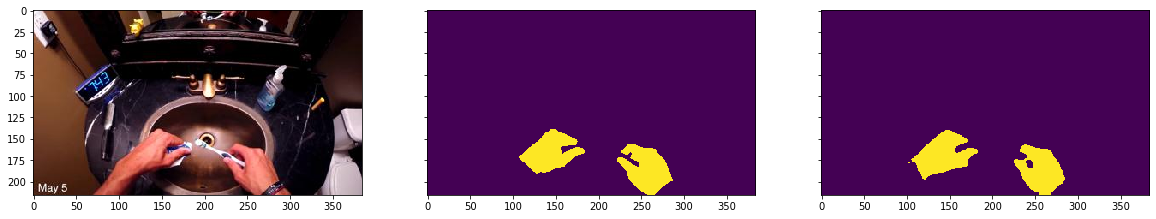

Image 39


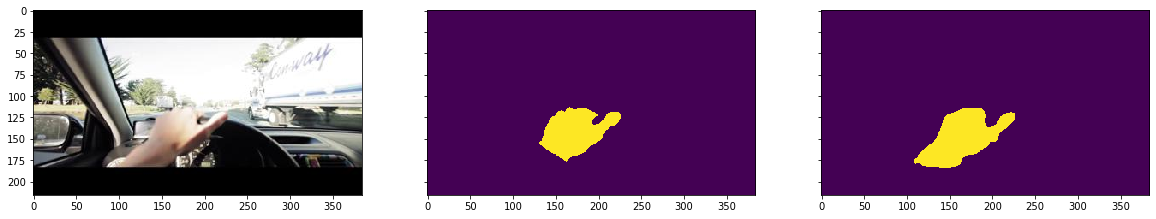

Image 40


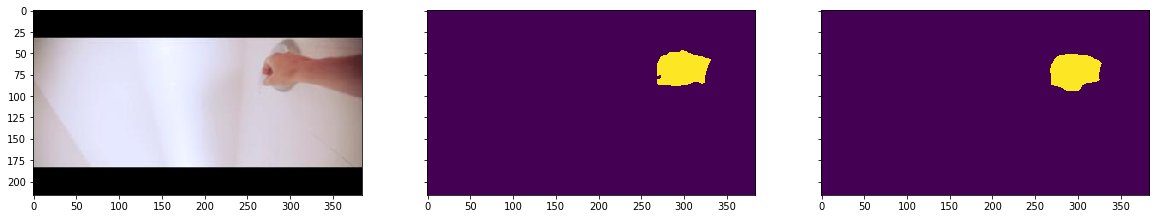

Image 41


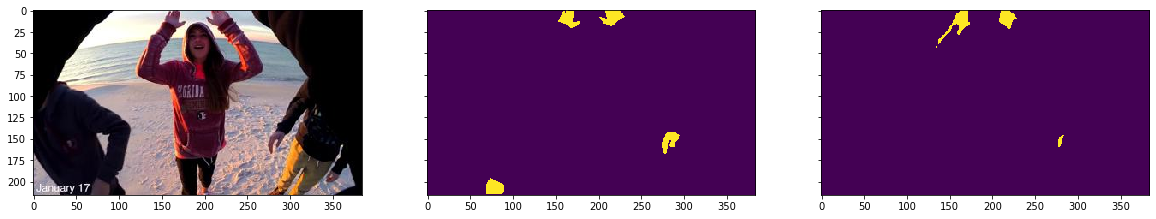

Image 42


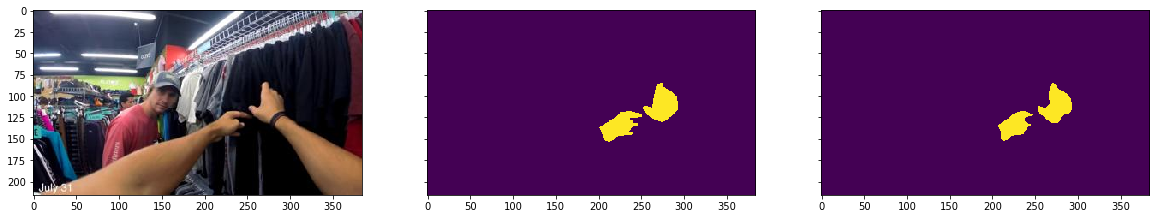

Image 43


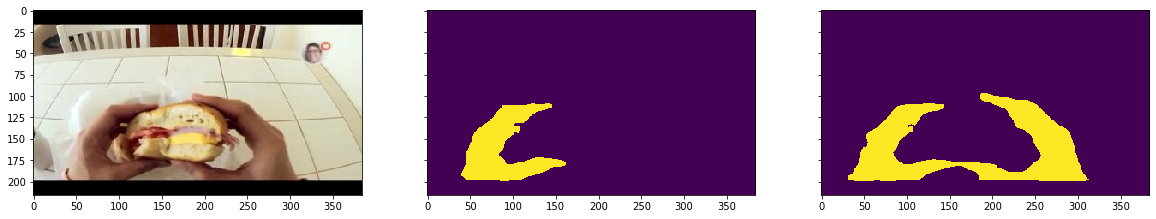

Image 44


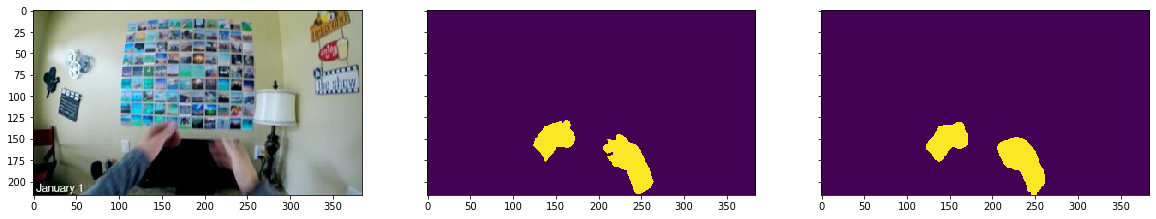

Image 45


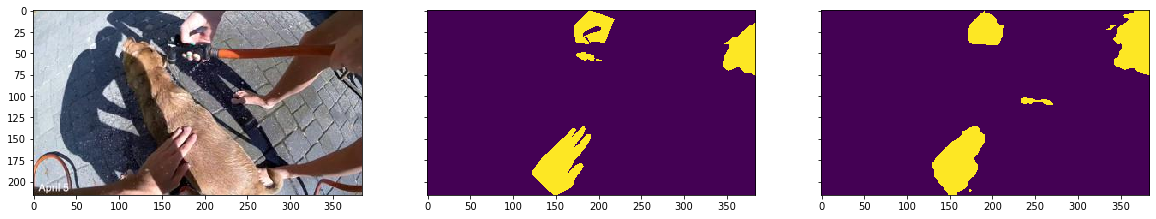

Image 46


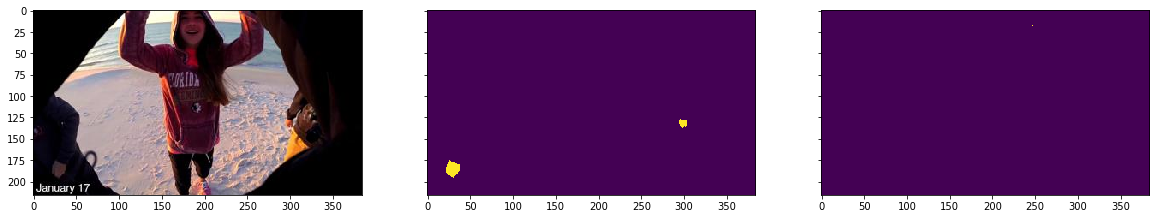

Image 47


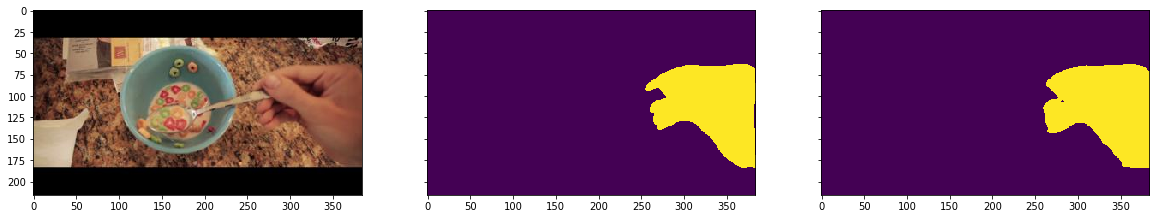

Image 48


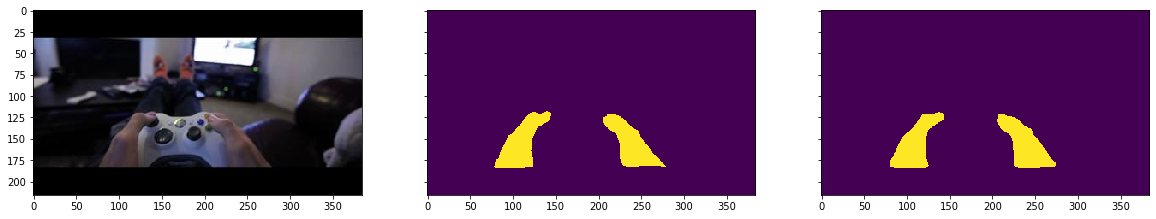

Image 49


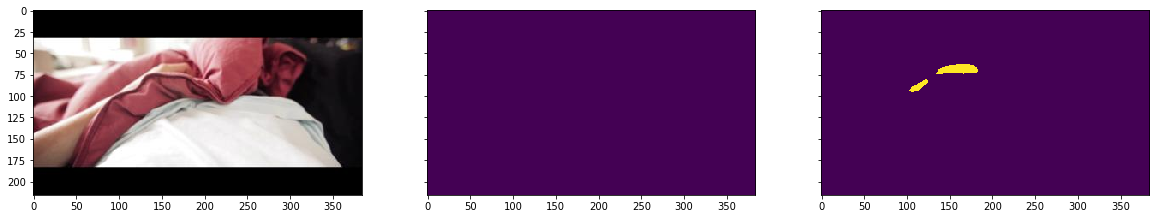

In [14]:
# visualize predicted hang segmentation mask 
dataset = HandDataset(mode="test")
for i in range(50):
    fig, axs = plt.subplots(1, 3, sharey=True)
    fig.set_figwidth(20)
    image, mask = dataset[i]
    # TODO: inference image and get the predicted_mask 
    ...
    
    image_rbg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("Image", i)
    axs[0].imshow(Image.fromarray(image_rbg))  # we convert numpy image to Pillow Image, in order to plot them 
    axs[1].imshow(Image.fromarray(mask))
    axs[2].imshow(Image.fromarray(predicted_mask))
    plt.show()